
# Image comparison with epipolar geometry

This notebook compares the two provided photos (`compfront.jpg` and `compright.jpg`) taken at different times from roughly the same pose. It uses feature matching to estimate the fundamental matrix, rectifies the views along their epipolar lines, and flags visual differences as potential anomalies.


In [66]:

# If needed, install dependencies (uncomment the next line).
# %pip install -q opencv-python-headless matplotlib numpy


In [67]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

plt.rcParams['figure.figsize'] = (10, 6)
start_time = time.perf_counter()
img_path_1 = Path('IMG_4356.jpg')
img_path_2 = Path('IMG_4358.jpg')

img1 = cv2.imread(str(img_path_1))
img2 = cv2.imread(str(img_path_2))
assert img1 is not None and img2 is not None, "Images not found; check the file names and paths."

# resize the pictures
img1 = cv2.resize(img1, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
img2 = cv2.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print(f"Loaded: {img_path_1} -> {gray1.shape}, {img_path_2} -> {gray2.shape}")


Loaded: IMG_4356.jpg -> (2016, 1512), IMG_4358.jpg -> (2016, 1512)


Detector: SIFT, keypoints -> img1: 1134, img2: 1549
Good matches after ratio test: 109


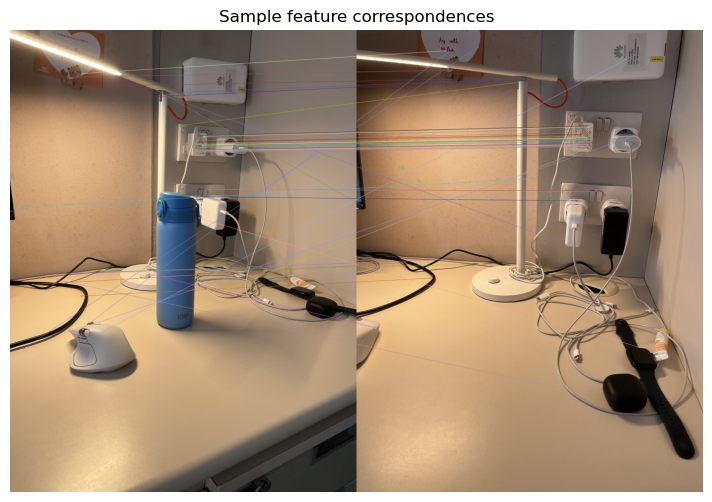

In [68]:

# Detect keypoints and descriptors
try:
    detector = cv2.SIFT_create()
    norm = cv2.NORM_L2
    method = 'SIFT'
except Exception:
    detector = cv2.ORB_create(nfeatures=4000)
    norm = cv2.NORM_HAMMING
    method = 'ORB'

kp1, des1 = detector.detectAndCompute(gray1, None)
kp2, des2 = detector.detectAndCompute(gray2, None)
print(f"Detector: {method}, keypoints -> img1: {len(kp1)}, img2: {len(kp2)}")

bf = cv2.BFMatcher(norm)
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test to keep good matches
good = []
ratio = 0.75
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)
print(f"Good matches after ratio test: {len(good)}")

# Visualize a sample of matches
matched_vis = cv2.drawMatches(img1, kp1, img2, kp2, good[:60], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(matched_vis, cv2.COLOR_BGR2RGB))
plt.title('Sample feature correspondences')
plt.axis('off')
plt.show()


Inliers: 55 / 109


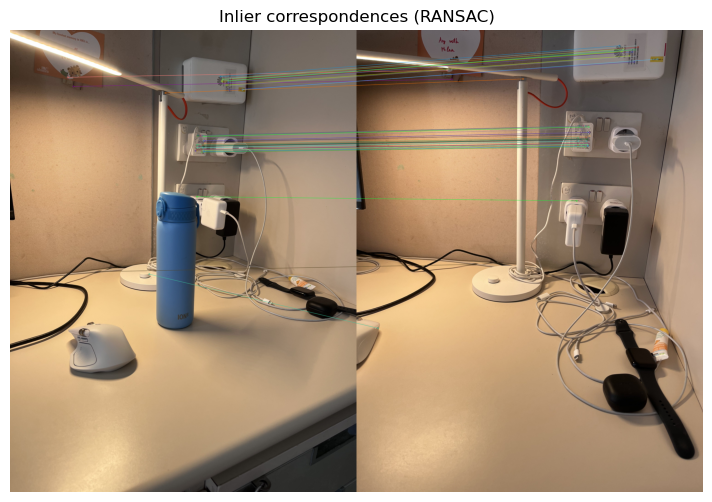

In [69]:

# Estimate fundamental matrix using RANSAC
if len(good) < 8:
    raise RuntimeError("Not enough matches to estimate the fundamental matrix (need >= 8).")

pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.99)
if F is None or mask is None:
    raise RuntimeError("Fundamental matrix estimation failed.")

inliers = mask.ravel().astype(bool)
pts1_in = pts1[inliers]
pts2_in = pts2[inliers]
print(f"Inliers: {pts1_in.shape[0]} / {len(good)}")

# Show inlier matches only
inlier_matches = [gm for gm, keep in zip(good, inliers) if keep]
vis_inliers = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches[:60], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(vis_inliers, cv2.COLOR_BGR2RGB))
plt.title('Inlier correspondences (RANSAC)')
plt.axis('off')
plt.show()


In [70]:

# Epipolar geometry check: distance of points to corresponding epipolar lines
lines1 = cv2.computeCorrespondEpilines(pts2_in.reshape(-1,1,2), 2, F).reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1_in.reshape(-1,1,2), 1, F).reshape(-1,3)

def point_line_distance(pt, line):
    a, b, c = line
    x, y = pt
    return abs(a*x + b*y + c) / np.hypot(a, b)

dists1 = np.array([point_line_distance(p, l) for p, l in zip(pts1_in, lines1)])
dists2 = np.array([point_line_distance(p, l) for p, l in zip(pts2_in, lines2)])
print(f"Mean epipolar distance img1->2: {dists1.mean():.3f} px, img2->1: {dists2.mean():.3f} px")


Mean epipolar distance img1->2: 0.277 px, img2->1: 0.352 px


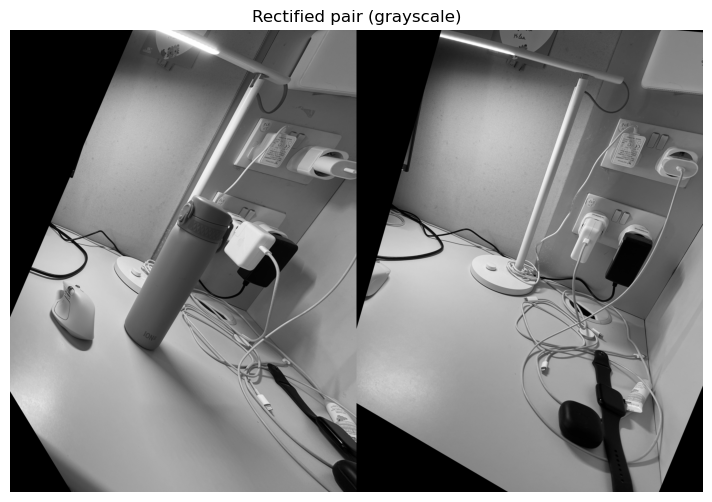

In [71]:

# Rectify the two uncalibrated views so epipolar lines become horizontal
h, w = gray1.shape
retval, H1, H2 = cv2.stereoRectifyUncalibrated(pts1_in, pts2_in, F, imgSize=(w, h))
if not retval:
    raise RuntimeError("Rectification failed.")

rect1 = cv2.warpPerspective(img1, H1, (w, h))
rect2 = cv2.warpPerspective(img2, H2, (w, h))
rect1_gray = cv2.cvtColor(rect1, cv2.COLOR_BGR2GRAY)
rect2_gray = cv2.cvtColor(rect2, cv2.COLOR_BGR2GRAY)

stack = np.hstack([rect1_gray, rect2_gray])
plt.imshow(stack, cmap='gray')
plt.title('Rectified pair (grayscale)')
plt.axis('off')
plt.show()


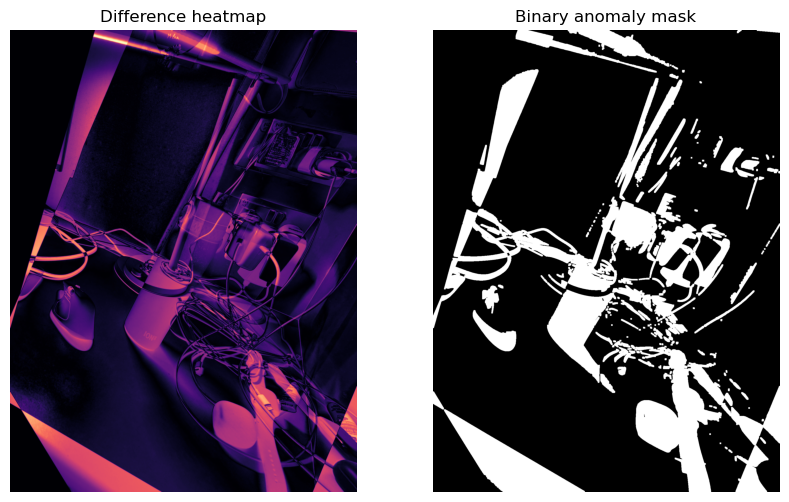

In [72]:

# Compute difference map on rectified images
blur1 = cv2.GaussianBlur(rect1_gray, (5,5), 0)
blur2 = cv2.GaussianBlur(rect2_gray, (5,5), 0)

absdiff = cv2.absdiff(blur1, blur2)
# Normalize for visualization
viz_diff = cv2.applyColorMap(cv2.normalize(absdiff, None, 0, 255, cv2.NORM_MINMAX), cv2.COLORMAP_MAGMA)

# Adaptive threshold (Otsu) to isolate significant changes
_, mask_thresh = cv2.threshold(absdiff, 10000, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask_thresh = cv2.morphologyEx(mask_thresh, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
mask_thresh = cv2.morphologyEx(mask_thresh, cv2.MORPH_DILATE, np.ones((5,5), np.uint8))

plt.subplot(1,2,1)
plt.imshow(viz_diff[:,:,::-1])
plt.title('Difference heatmap')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_thresh, cmap='gray')
plt.title('Binary anomaly mask')
plt.axis('off')
plt.show()


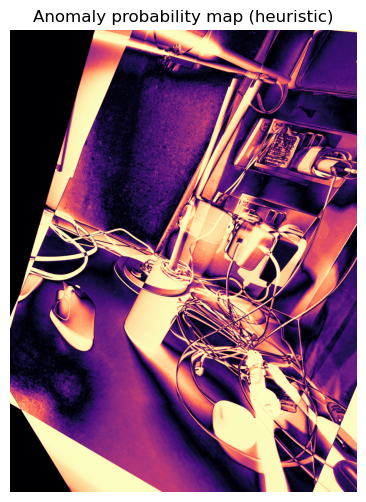

In [73]:
# Convert difference image into an anomaly probability map (heuristic)
absdiff_f = absdiff.astype(np.float32)

median = np.median(absdiff_f)
mad = np.median(np.abs(absdiff_f - median)) + 1e-6
z = (absdiff_f - median) / (1.4826 * mad)

# Squash to [0,1] with a sigmoid. Larger differences -> higher probability.
prob_map = 1 / (1 + np.exp(-z))

plt.imshow(prob_map, cmap='magma')
plt.title('Anomaly probability map (heuristic)')
plt.axis('off')
plt.show()


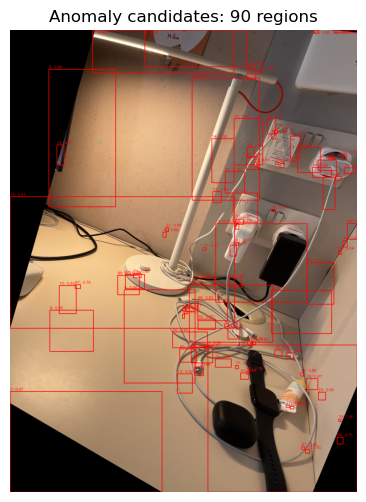

Anomalies (sorted by probability):
  id=1, prob=0.975, bbox=(x=0, y=1577, w=662, h=439), area=74326
  id=2, prob=0.965, bbox=(x=587, y=0, w=443, h=160), area=20070
  id=3, prob=0.963, bbox=(x=862, y=1374, w=650, h=642), area=147633
  id=4, prob=0.958, bbox=(x=497, y=1133, w=309, h=407), area=55272
  id=5, prob=0.957, bbox=(x=169, y=171, w=291, h=600), area=52549
  id=6, prob=0.952, bbox=(x=173, y=1222, w=190, h=180), area=12445
  id=7, prob=0.948, bbox=(x=360, y=0, w=615, h=186), area=15790
  id=8, prob=0.926, bbox=(x=1253, y=512, w=100, h=110), area=5213
  id=9, prob=0.926, bbox=(x=793, y=209, w=294, h=533), area=29157
  id=10, prob=0.923, bbox=(x=214, y=1115, w=74, h=122), area=5002
  id=11, prob=0.919, bbox=(x=1342, y=567, w=80, h=46), area=2488
  id=12, prob=0.918, bbox=(x=896, y=845, w=398, h=342), area=47673
  id=13, prob=0.916, bbox=(x=729, y=1500, w=65, h=84), area=2286
  id=14, prob=0.915, bbox=(x=879, y=474, w=97, h=192), area=4945
  id=15, prob=0.915, bbox=(x=0, y=727, w=978

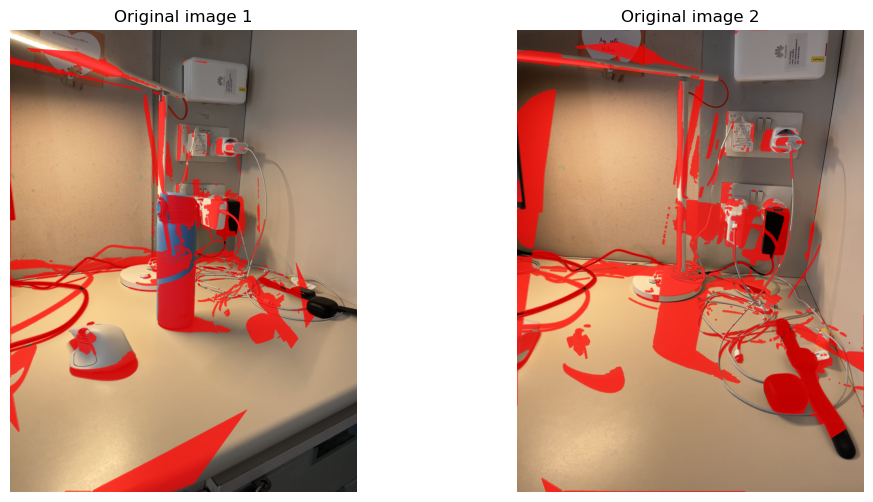

Total running time: 2.65 seconds


In [74]:
# Extract bounding boxes of potential anomalies and compute probabilities
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_thresh)
anomalies = []

for label in range(1, num_labels):
    x, y, w, h, area = stats[label]
    if area < 100:  # filter tiny noise blobs
        continue
    region_mask = (labels[y:y+h, x:x+w] == label)
    region_probs = prob_map[y:y+h, x:x+w][region_mask]
    region_prob = float(region_probs.mean()) if region_probs.size else 0.0
    anomalies.append({
        'bbox': (int(x), int(y), int(w), int(h)),
        'area': int(area),
        'probability': region_prob,
    })

anomalies_sorted = sorted(anomalies, key=lambda a: a['probability'], reverse=True)

overlay = rect2.copy()
for idx, item in enumerate(anomalies_sorted, 1):
    x, y, w, h = item['bbox']
    prob = item['probability']
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 0, 255), 2)
    label = f"{idx}: {prob:.2f}"
    cv2.putText(overlay, label, (x, max(y - 5, 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Anomaly candidates: {len(anomalies_sorted)} regions')
plt.axis('off')
plt.show()

if anomalies_sorted:
    print('Anomalies (sorted by probability):')
    for idx, item in enumerate(anomalies_sorted, 1):
        x, y, w, h = item['bbox']
        print(f"  id={idx}, prob={item['probability']:.3f}, bbox=(x={x}, y={y}, w={w}, h={h}), area={item['area']}")
else:
    print('No anomalies detected above the area threshold.')

# Warp anomaly mask and probability map back to original images for highlighting
H1_inv = np.linalg.inv(H1)
H2_inv = np.linalg.inv(H2)

mask_on_img1 = cv2.warpPerspective(mask_thresh, H1_inv, (img1.shape[1], img1.shape[0]))
mask_on_img2 = cv2.warpPerspective(mask_thresh, H2_inv, (img2.shape[1], img2.shape[0]))

prob_on_img1 = cv2.warpPerspective(prob_map, H1_inv, (img1.shape[1], img1.shape[0]))
prob_on_img2 = cv2.warpPerspective(prob_map, H2_inv, (img2.shape[1], img2.shape[0]))

# Gate probabilities to only the detected anomaly mask
prob_on_img1[mask_on_img1 == 0] = 0
prob_on_img2[mask_on_img2 == 0] = 0

def overlay_prob(image, prob, color=(0, 0, 255), min_alpha=0.15, max_alpha=0.75):
    prob = np.clip(prob, 0, 1)
    alpha = min_alpha + (max_alpha - min_alpha) * prob
    alpha = alpha * (prob > 0)
    alpha_3 = alpha[..., None]
    color_layer = np.zeros_like(image)
    color_layer[:] = color
    blended = (image * (1 - alpha_3) + color_layer * alpha_3).astype(np.uint8)
    return blended

overlay_img1 = overlay_prob(img1, prob_on_img1)
overlay_img2 = overlay_prob(img2, prob_on_img2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_img1, cv2.COLOR_BGR2RGB))
plt.title('Original image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_img2, cv2.COLOR_BGR2RGB))
plt.title('Original image 2')
plt.axis('off')
plt.show()

total_runtime_sec = time.perf_counter() - start_time
print(f"Total running time: {total_runtime_sec:.2f} seconds")



**How it works**
- Detect local features in both images, match them, and keep high-confidence pairs.
- Estimate the fundamental matrix with RANSAC to model epipolar geometry between the views.
- Rectify both images using the fundamental matrix so epipolar lines align horizontally; this makes change detection more reliable along corresponding scanlines.
- Compute a blurred absolute-difference image, binarize with Otsu's method, clean with morphology, and report connected components as anomaly candidates.
- Saved files: `rectified_1.png`, `rectified_2.png`, `anomaly_mask.png`, `anomaly_overlay.png`.

- Also saved: `anomaly_prob_map.png` (heuristic per-pixel anomaly probability).
- Also saved: `anomaly_overlay_original1.png`, `anomaly_overlay_original2.png` (anomalies highlighted on the original images).
